In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

from scipy.stats import entropy

from utils.simulation import *
from utils.mutual import (compute_mutual_information_from_trajectories, mutual_information_slowjumps, MC_underhood, mutual_information_slowjumps_fixedw)
from utils.plotting import *
from utils.analytical import *

data_folder = 'data/'
folder_figures = 'figures/'
format_fig = '.svg'
lw = 2

In [2]:
def get_default_params_system():
    ### Info system
    N = 2
    w = 2
    k = 1.1
    tau_ei = 1
    r = np.ones(N)
    
    return {'N': N, 'w': w, 'k': k, 'tau_ei': tau_ei, 'r': r}

# Figure 1 - Role of timescales

### Example of trajectory for slow timescale

In [3]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [4]:
### Simulate state
#inputs_slow, states_slow = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)

### Store data
#np.save(data_folder+'inputs_slow.npy', inputs_slow)
#np.save(data_folder+'states_slow.npy', states_slow)

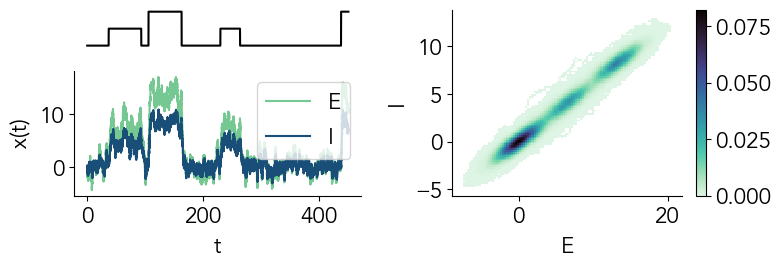

In [4]:
### Plot simulation
inputs_slow = np.load(data_folder+'inputs_slow.npy')
states_slow = np.load(data_folder+'states_slow.npy')

plot_simulation(states_slow, inputs_slow, hs[0], dt, fname='fig_1_example_slow', max_steps_to_plot=int(9e4))

### Example of trajectory for fast timescale

In [5]:
### Info input
M = 3
tau_h = 8
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info simulation
steps = int(5e6)
dt = 0.005

### Create info dictionary
info_system = create_info_system(**get_default_params_system())
info_input = create_info_input(W, hs)
info_simulation = create_info_simulation(steps,dt)

In [6]:
### Simulate state
#inputs_fast, states_fast = simulate_coupled_system(info_system, info_input, info_simulation, seed=2)

### Store data
#np.save(data_folder+'inputs_fast.npy', inputs_fast)
#np.save(data_folder+'states_fast.npy', states_fast)

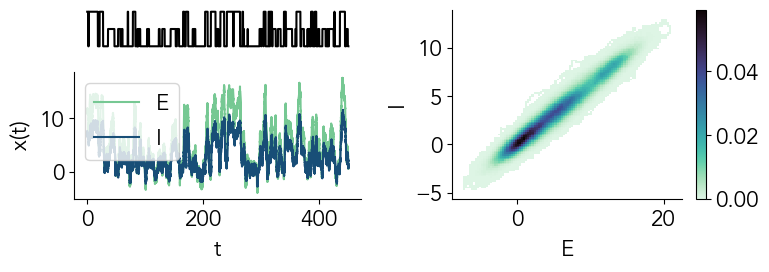

In [7]:
### Plot simulation
inputs_fast = np.load(data_folder+'inputs_fast.npy')
states_fast = np.load(data_folder+'states_fast.npy')

plot_simulation(states_fast, inputs_fast, hs[0], dt, fname='fig_1_example_fast', max_steps_to_plot=int(9e4))

### Compute MI by varying tau_jumps

In [5]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

### Info system - increase w
info_system['w'] = 5 # was 40

In [6]:
### Compute bounds
upper_bound = theo_ub(info_system['w'], info_system['k'], p_stat, info_input['hs'])
lower_bound = theo_lb(info_system['w'], info_system['k'], p_stat, info_input['hs'])

print(lower_bound, upper_bound)

0.814123715841931 1.037052357929819


In [10]:
### Simulation params
taus = np.logspace(-1,3,10)
bins = 100

### Info simulation
steps = int(1e7)
dt = 0.01

In [7]:
'''
ress = np.zeros(taus.size)

for idx, tau in enumerate(taus):
    print(f'[*] tau={tau}')
    ### Info input
    wup = 1 / tau
    wdown = 2 / tau

    W = create_transition_matrix_star_graph(M, wup, wdown)
    
    ### Create info dictionaries
    info_input = create_info_input(W, hs)
    info_simulation = create_info_simulation(steps,dt)
    
    ### Simulate state
    inputs, states = simulate_coupled_system(info_system, info_input, info_simulation)
    
    ### Compute MI
    ress[idx] = compute_mutual_information_from_trajectories(states, inputs, bins)
    
### Store mutual
np.save(data_folder+'mutual_different_timescales.npy', ress)
'''

"\nress = np.zeros(taus.size)\n\nfor idx, tau in enumerate(taus):\n    print(f'[*] tau={tau}')\n    ### Info input\n    wup = 1 / tau\n    wdown = 2 / tau\n\n    W = create_transition_matrix_star_graph(M, wup, wdown)\n    \n    ### Create info dictionaries\n    info_input = create_info_input(W, hs)\n    info_simulation = create_info_simulation(steps,dt)\n    \n    ### Simulate state\n    inputs, states = simulate_coupled_system(info_system, info_input, info_simulation)\n    \n    ### Compute MI\n    ress[idx] = compute_mutual_information_from_trajectories(states, inputs, bins)\n    \n### Store mutual\nnp.save(data_folder+'mutual_different_timescales.npy', ress)\n"

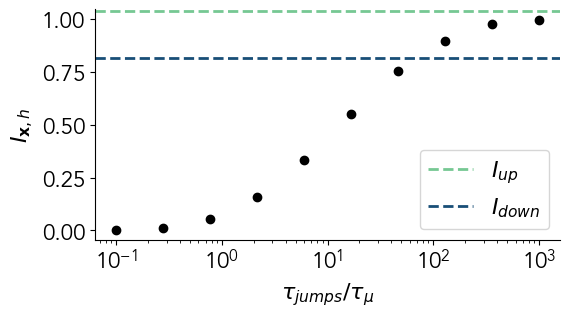

In [11]:
### Load mutual
ress = np.load(data_folder+'mutual_different_timescales.npy')

plt.figure(figsize=(6,3))
plt.plot(taus / info_system['tau_ei'], ress, 'o', c='k')
#plt.axhline(entropy(p_stat), c='gray', ls='--', lw=lw, label=r'$H_{jumps}$')
plt.axhline(upper_bound, c=colors[0], ls='--', lw=lw, label=r'$I_{up}$')
plt.axhline(lower_bound, c=colors[1], ls='--', lw=lw, label=r'$I_{down}$')
plt.xscale('log')
plt.xlabel(r'$\tau_{jumps} / \tau_{\mu}$')
plt.ylabel(r'$I_{\mathbf{x},h}$')
plt.legend()
sns.despine()

plt.savefig(folder_figures+'fig_1_empirical_timescales'+format_fig, transparent=True)

plt.show()

# Figure 2 - Edge of stability

In [4]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [5]:
### Compute bounds

#kmin, kmax = 0.1, 2.
#wmin, wmax = 0.5, 100

kmin, kmax = 0., 1.5
wmin, wmax = 0.01, 10

nk, nw = int(5e2), int(5e2)

ks, ws = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ks, Ws = np.meshgrid(ks, ws)

unstable = np.where(1 + Ws*(Ks-1)<=0)

Z = theo_W_factor(Ws, Ks)
Z[unstable] = np.nan

lbs = np.zeros(Ks.shape)
ubs = np.zeros(Ks.shape)

for (idx_x, idx_y) in np.ndindex(Ks.shape):
    if np.isnan(Z[idx_x, idx_y]):
        continue
    w, k = Ws[idx_x, idx_y], Ks[idx_x, idx_y]
    lbs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'lb')
    ubs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'ub')
    
lbs[unstable] = np.nan
ubs[unstable] = np.nan

print(entropy(p_stat), np.nanmax(ubs), np.nanmax(lbs), np.nanmax(Z))

1.0397207708399179 1.0397207708399179 1.0397207708399179 92922.67644879733


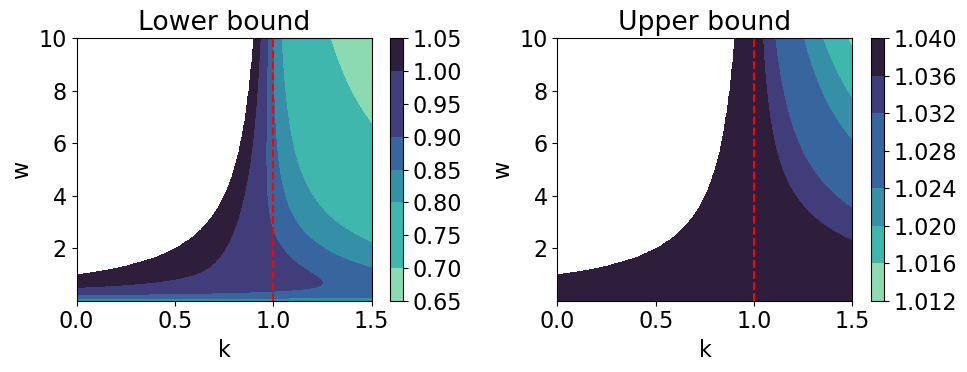

In [6]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.contourf(Ks, Ws, lbs, cmap=my_cmap_discrete) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Lower bound')

plt.subplot(1,2,2)
plt.contourf(Ks, Ws, ubs, cmap=my_cmap_discrete) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Upper bound')

plt.tight_layout()
plt.show()

In [7]:
kmin, kmax = 0., 5
wmin, wmax = 0.01, 10

nk, nw = int(5e2), int(5e2)

ks, ws = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

Ks, Ws = np.meshgrid(ks, ws)

unstable = np.where(1 + Ws*(Ks-1)<=0)

Z = theo_W_factor(Ws, Ks)
Z[unstable] = np.nan

lbs = np.zeros(Ks.shape)
ubs = np.zeros(Ks.shape)

for (idx_x, idx_y) in np.ndindex(Ks.shape):
    if np.isnan(Z[idx_x, idx_y]):
        continue
    w, k = Ws[idx_x, idx_y], Ks[idx_x, idx_y]
    lbs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'lb')
    ubs[idx_x, idx_y] = theo_bound(w, k, p_stat, hs, 'ub')
    
lbs[unstable] = np.nan
ubs[unstable] = np.nan

print(entropy(p_stat), np.nanmax(ubs), np.nanmax(lbs), np.nanmax(Z))

1.0397207708399179 1.0397207708399179 1.0397207708399179 51685.15185669273


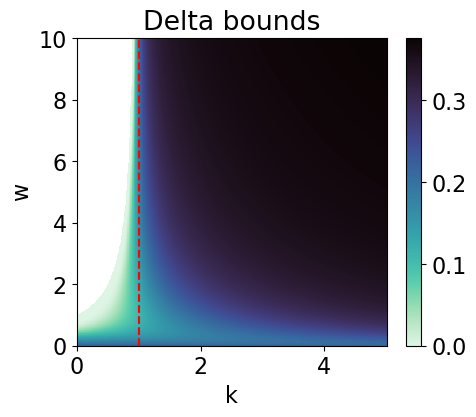

In [8]:
plt.figure(figsize=(5,4))

plt.pcolormesh(Ks, Ws, ubs-lbs, cmap=my_cmap_continuous) #, vmin=0, vmax=entropy(p_stat)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.axvline(1, c='r', ls='--')
plt.title('Delta bounds')

#plt.savefig(folder_figures+'fig_2_mutual_bounds_delta'+format_fig, transparent=True)

plt.show()

### Plot mutual from Pjoint with importance sampling

In [9]:
### Info input
M = 3
tau_h = 100
wup = 1 / tau_h
wdown = 2 / tau_h
delta_h = 2.5
hs = np.arange(M) * delta_h
hs = np.stack([hs, np.zeros(M)])

W = create_transition_matrix_star_graph(M, wup, wdown)

p_stat = np.array([wdown] + [wup] * (M-1))
p_stat = p_stat / p_stat.sum()

In [10]:
### Define grid params
kmin, kmax = 0., 5
wmin, wmax = 0.01, 10

nk, nw = int(2e2), int(2e2)

k_list, w_list = np.linspace(kmin, kmax, nw), np.linspace(wmin, wmax, nw)

print(w_list.size * k_list.size)

40000


In [11]:
### Compute mutual
#mutuals = mutual_information_slowjumps(w_list, k_list, hs, p_stat, nsamples = int(1e5))
#np.save(data_folder+'mutual_importance_sampling.npy', mutuals)

In [12]:
### Load results
mutuals = np.load(data_folder+'mutual_importance_sampling.npy')

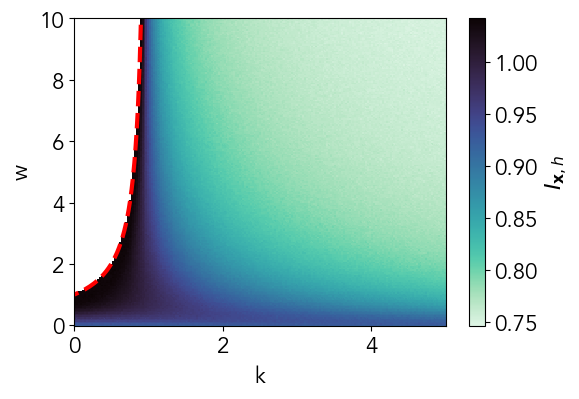

In [15]:
Ws, Ks = np.meshgrid(w_list, k_list)

plt.figure(figsize=(6,4))

plt.pcolor(Ks, Ws, mutuals.T, cmap=my_cmap_continuous)

plt.plot(1-1/w_list, w_list, ls='--', c='red', lw=3)

plt.xlim(kmin,None)

plt.xlabel('k')
plt.ylabel('w')

cbar = plt.colorbar()
cbar.ax.set_ylabel(r'$I_{\mathbf{x},h}$')

plt.savefig(folder_figures+'fig2_slow'+format_fig, transparent=True)

plt.show()

In [138]:
### Compute bounds
info_input = create_info_input(W, hs)

w = 10
print('w:', w)
k_crit = 1 - 1/w
print('k_crit:', k_crit)

k_max = 200
k_list_log = np.geomspace(1e-3, k_max, 75) + k_crit

bounds_up = [theo_ub(w, k, p_stat, info_input['hs']) for k in k_list_log]
bounds_down = [theo_lb(w, k, p_stat, info_input['hs']) for k in k_list_log]

bounds_up = np.array(bounds_up)
bounds_down = np.array(bounds_down)

mutuals = mutual_information_slowjumps_fixedw(w, k_list_log, hs, p_stat, nsamples = int(2e6))
np.save(data_folder+f'mutual_importance_sampling_fixedw{w}_logspace.npy', mutuals)
np.save(data_folder+f'k_list_fixedw{w}_logspace.npy', k_list_log)
np.save(data_folder+f'bounds_up_fixedw{w}_logspace.npy', bounds_up)
np.save(data_folder+f'bounds_down_fixedw{w}_logspace.npy', bounds_down)

w: 10
k_crit: 0.9


In [135]:
w = 10
print('w:', w)
k_crit = 1 - 1/w
print('k_crit:', k_crit)

k_max = 5
k_list = np.linspace(k_crit, k_max, 60)
k_list = np.concatenate([np.linspace(k_crit, k_crit + 0.25, 25), k_list])
k_list = np.sort(k_list)

bounds_up = [theo_ub(w, k, p_stat, info_input['hs']) for k in k_list]
bounds_down = [theo_lb(w, k, p_stat, info_input['hs']) for k in k_list]

bounds_up = np.array(bounds_up)
bounds_down = np.array(bounds_down)

mutuals = mutual_information_slowjumps_fixedw(w, k_list, hs, p_stat, nsamples = int(2e6))
np.save(data_folder+f'mutual_importance_sampling_fixedw{w}.npy', mutuals)
np.save(data_folder+f'k_list_fixedw{w}.npy', k_list)
np.save(data_folder+f'bounds_up_fixedw{w}.npy', bounds_up)
np.save(data_folder+f'bounds_down_fixedw{w}.npy', bounds_down)

w: 10
k_crit: 0.9


In [130]:
### Compute bounds
info_input = create_info_input(W, hs)

In [137]:
w = 1.05
print('w:', w)
k_crit = 1 - 1/w
print('k_crit:', k_crit)

k_max = 200
k_list_log = np.geomspace(1e-3, k_max, 75) + k_crit

bounds_up = [theo_ub(w, k, p_stat, info_input['hs']) for k in k_list_log]
bounds_down = [theo_lb(w, k, p_stat, info_input['hs']) for k in k_list_log]

bounds_up = np.array(bounds_up)
bounds_down = np.array(bounds_down)

mutuals = mutual_information_slowjumps_fixedw(w, k_list_log, hs, p_stat, nsamples = int(2e6))
np.save(data_folder+f'mutual_importance_sampling_fixedw{w}_logspace.npy', mutuals)
np.save(data_folder+f'k_list_fixedw{w}_logspace.npy', k_list_log)
np.save(data_folder+f'bounds_up_fixedw{w}_logspace.npy', bounds_up)
np.save(data_folder+f'bounds_down_fixedw{w}_logspace.npy', bounds_down)

w: 1.05
k_crit: 0.04761904761904767


In [136]:
w = 1.05
print('w:', w)
k_crit = 1 - 1/w
print('k_crit:', k_crit)

k_max = 5
k_list = np.linspace(k_crit + 0.01, k_max, 75)

bounds_up = [theo_ub(w, k, p_stat, info_input['hs']) for k in k_list]
bounds_down = [theo_lb(w, k, p_stat, info_input['hs']) for k in k_list]

bounds_up = np.array(bounds_up)
bounds_down = np.array(bounds_down)

mutuals = mutual_information_slowjumps_fixedw(w, k_list, hs, p_stat, nsamples = int(2e6))
np.save(data_folder+f'mutual_importance_sampling_fixedw{w}.npy', mutuals)
np.save(data_folder+f'k_list_fixedw{w}.npy', k_list)
np.save(data_folder+f'bounds_up_fixedw{w}.npy', bounds_up)
np.save(data_folder+f'bounds_down_fixedw{w}.npy', bounds_down)

w: 1.05
k_crit: 0.04761904761904767


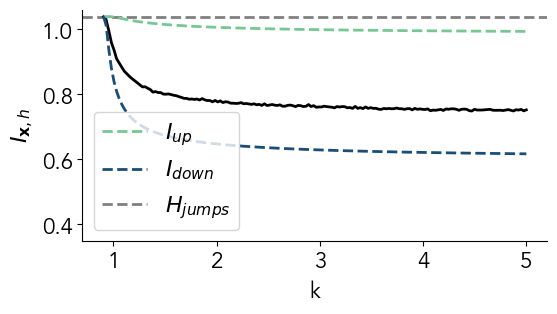

In [33]:
plt.figure(figsize=(6,3))
idx_w = 199
plt.plot(k_list, mutuals[idx_w], c='k', lw=lw)
plt.plot(k_list, bounds_up, c=colors[0], ls='--', lw=lw, label=r'$I_{up}$', zorder=2)
plt.plot(k_list, bounds_down, c=colors[1], ls='--', lw=lw, label=r'$I_{down}$', zorder=2)

plt.axhline(entropy(p_stat), c='gray', ls='--', lw=lw, label=r'$H_{jumps}$', zorder=0)

plt.ylim(0.35, None)

plt.legend()
sns.despine()
plt.xlabel('k')
plt.ylabel(r'$I_{\mathbf{x},h}$')

plt.savefig(folder_figures+'fig2_slow_reduced_with_bounds'+format_fig, transparent=True)

plt.show()

# Figure 3 - Time dependent

In [229]:
w = 5
k = 1.1
sigmah = 1

k = 1.1
ws = [0.1, 0.4, 1, 2, 5, 100]

tmin = -1
tmax = 6
dt = 0.01

ts = np.arange(0, tmax, dt)
tstim = np.arange(tmin, tmax, dt)

In [230]:
### Compute mutual
I_t = [mutual_time_dependent(w, k, sigmah, ts) for w in ws]
I_t = np.array(I_t)

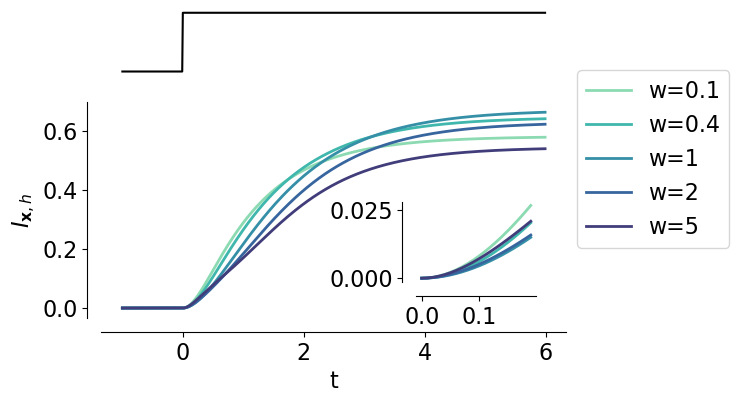

In [213]:
### Params for plot
# Axes ratio
height_ratios = [0.3, 1]

# Define maximum time index of inset
idx_max = 20

# Define stimulus properties
h_stim = 0.5
stim = np.zeros(tstim.size)
stim[tstim>0] = h_stim

# Inset position
left, bottom, width, height = [0.65, 0.2, 0.2, 0.2]

# Define legend position
bbox_to_anchor = (1, 1, 0.2, 0.2)

### PLOT FIGURE
fig = plt.figure(figsize=(6,4))
gs = gridspec.GridSpec(2, 1, height_ratios=height_ratios)

# Plot stimulus
ax_stim = fig.add_subplot(gs[0,0])
ax_stim.plot(tstim, stim, c='k')
ax_stim.axis('off')

### Large plot
#ax1 = plt.subplot(1,1,1)
ax1 = fig.add_subplot(gs[1,0])

for idx_w, w in enumerate(ws):
    ax1.plot(tstim, np.concatenate( [np.zeros(tstim.size-ts.size),I_t[idx_w]] ), lw=lw, label=f'w={w}', c=my_cmap_discrete(idx_w/len(ws)))
#plt.xscale('log')

ax1.set_xlabel('t')
ax1.set_ylabel(r'$I_{\mathbf{x},h}$')

plt.legend(ncol=1, bbox_to_anchor=bbox_to_anchor)

### Inset
ax2 = fig.add_axes([left, bottom, width, height])

for idx_w, w in enumerate(ws):
    ax2.plot(ts[:idx_max], I_t[idx_w][:idx_max], lw=lw, label=f'w={w}', c=my_cmap_discrete(idx_w/len(ws)))
    
sns.despine(offset=10)

plt.savefig(folder_figures+'fig3_time_dependent_examples'+format_fig, transparent=True)

plt.show()

In [191]:
kmin, kmax = 0.01, 5
wmin, wmax = 0.01, 10

nk, nw = int(5e2), int(5e2)

ws = np.linspace(wmin, wmax, nw)
Ks = np.zeros((nw, nk))
Ws = np.zeros((nw, nk))

for idx_w, w in enumerate(ws):
    kcrit = 1 - 1/w
    if w <=1:
        k_list = np.linspace(kmin, kmax, nk)
    else:
        k_list = np.geomspace(1e-6, kcrit/2, 200) + kcrit
        k_list = np.concatenate([np.linspace(kcrit*(1 + 1/2), kmax, nk - 200), k_list])
    Ks[idx_w] = np.sort(k_list)
    Ws[idx_w] = w

unstable = np.where(1 + Ws*(Ks-1)<=0)

Z = np.zeros(Ks.shape)
SDer = np.zeros(Ks.shape)

for idx_w, w in enumerate(ws):
    for idx_k, k in enumerate(Ks[idx_w]):
        if 1 + w*(k-1)<=0:
            Z[idx_w, idx_k] = np.nan
            SDer[idx_w, idx_k] = np.nan
        else:
            Z[idx_w, idx_k] = product_mutual_st_second_der(w, k, sigmah)
            SDer[idx_w, idx_k] = mutual_second_der(w, k, sigmah)

/var/folders/tq/vdh27z_571gbg17w072s1p7h0000gn/T/ipykernel_82096/3125659667.py:4: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Ks, Ws, SDer, cmap=my_cmap_continuous)


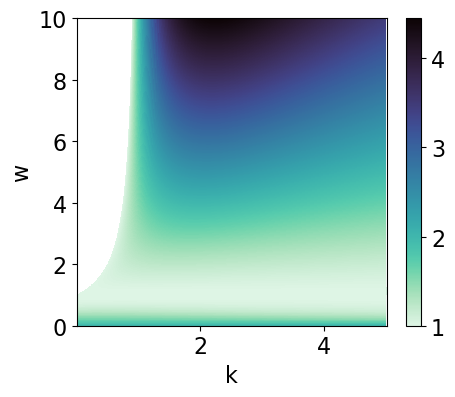

In [233]:
# plot Z
plt.figure(figsize=(5,4))

plt.pcolormesh(Ks, Ws, SDer, cmap=my_cmap_continuous)
plt.colorbar()
plt.xlabel('k')
plt.ylabel('w')
plt.show()

Text(0.5, 0, '$\\frac{\\partial^2 I}{\\partial w \\partial k}$')

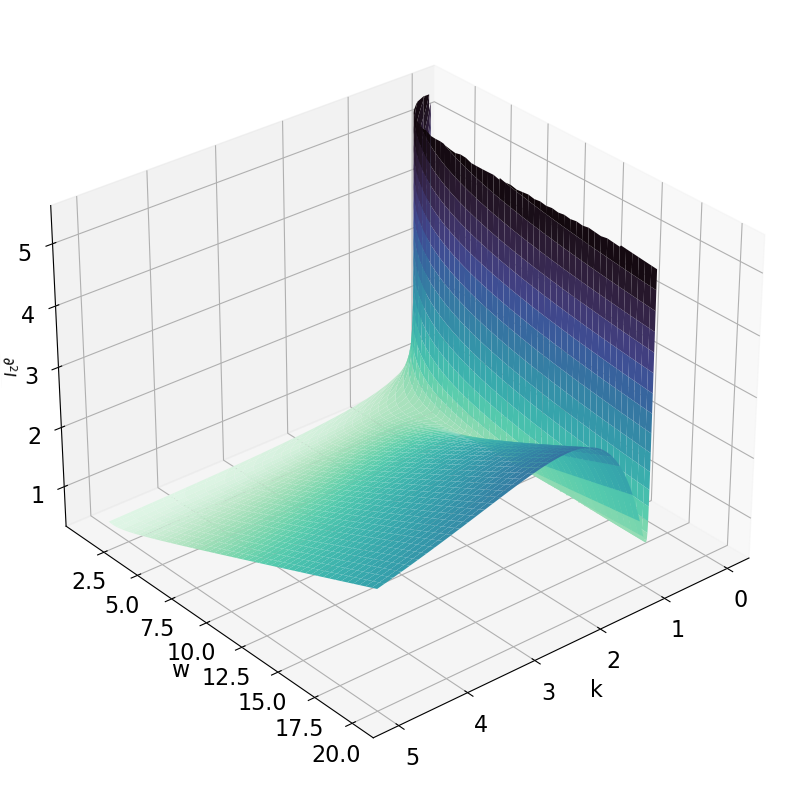

In [189]:
Zplot = Z.copy()
Wsplot = Ws.copy()
Ksplot = Ks.copy()
Wsplot[Wsplot <= 1] = np.nan
Ksplot[Wsplot <= 1] = np.nan
Zplot[Wsplot <= 1] = np.nan
Zplot[Zplot > 5.5] = np.nan

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(Ksplot, Wsplot, Zplot, cmap=my_cmap_continuous)

ax.view_init(30, 50)
ax.set_xlabel('k')
ax.set_ylabel('w')
ax.set_zlabel(r'$\frac{\partial^2 I}{\partial w \partial k}$')

#ax.set_zlim(0., 2)

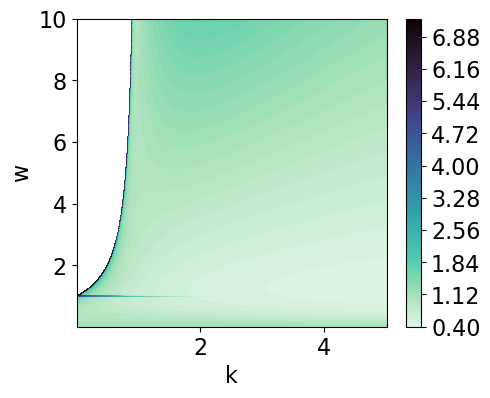

In [166]:
plt.figure(figsize=(5,4))

plt.contourf(Ks, Ws, Z, cmap=my_cmap_continuous, levels=100) #, vmin=0, vmax=entropy(p_stat)
#plt.plot(1-1/w_list, w_list, ls='--', c='red', lw=3)
plt.colorbar()

plt.xlim(kmin, None)

plt.xlabel('k')
plt.ylabel('w')
#plt.title('')

plt.show()

Text(0, 0.5, 'w')

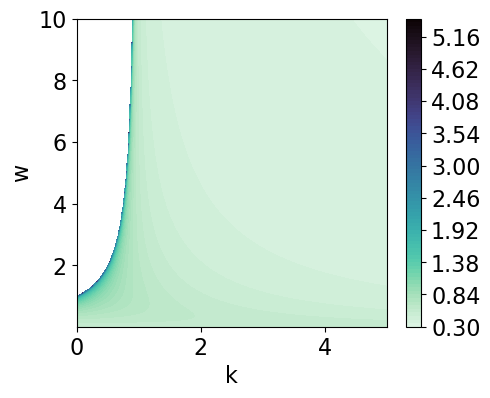

In [12]:
plt.figure(figsize=(5,4))

plt.contourf(Ks, Ws, Z/SDer, cmap=my_cmap_continuous, levels=100) #, vmin=0, vmax=entropy(p_stat)
#plt.plot(1-1/w_list, w_list, ls='--', c='red', lw=3)
plt.colorbar()

plt.xlim(kmin, None)

plt.xlabel('k')
plt.ylabel('w')

Text(0, 0.5, 'w')

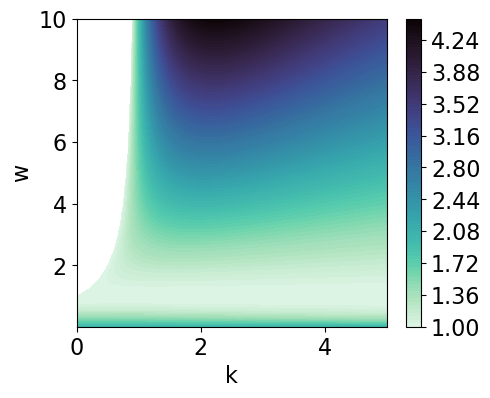

In [11]:
plt.figure(figsize=(5,4))

plt.contourf(Ks, Ws, SDer, cmap=my_cmap_continuous, levels=100) #, vmin=0, vmax=entropy(p_stat)
#plt.plot(1-1/w_list, w_list, ls='--', c='red', lw=3)
plt.colorbar()

plt.xlim(kmin, None)

plt.xlabel('k')
plt.ylabel('w')

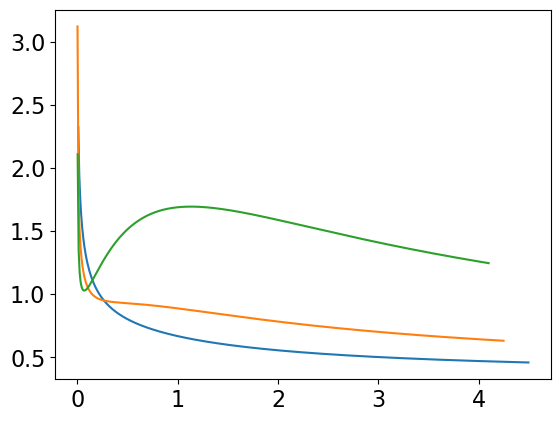

In [190]:
plt.plot(Ks[0] - (1 - 1/Ws[100, 0]), Z[100])
plt.plot(Ks[0]- (1 - 1/Ws[200, 0]), Z[200])
plt.plot(Ks[0]- (1 - 1/Ws[-1, 0]), Z[-1])

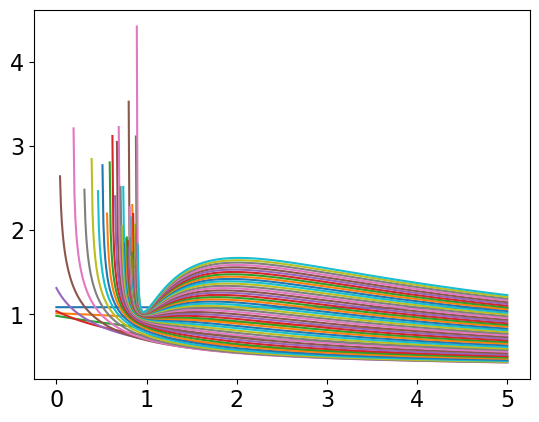

In [182]:
for idx in np.arange(1,500,10):
    plt.plot(Ks[idx], Z[idx])